<a href="https://colab.research.google.com/github/mobinsaidy/ML_Final_Exam/blob/main/Final_Exam_Mobin_Saidy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Exam - Air pullution(question 1)**
Mobin Saidy - 96100833

In this notebook i will try to make a model which predicts tehran's air Pullution. 
if we want to predict more precisely, we should make a model for each region of tehran and predict depending on region. for simplicity we only make a model for one of the regions (in fact the station we get our data is located at the border of region 6 and 11, so somehow we will make a model for parts of these two regions which are closer to their border) and for other regions we should get the data of stations located in them and the process we do here for them.
the model we build will get a day's average temperture, pressure and wind speed and predict the next day's air pollution.

first we import needed libraries:

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor

we write a function which helps us plot learning curve:

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1, 10)):
    
    plt.figure(figsize=(10, 6), dpi=80)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

we write a function which helps us plot validation curve:

In [3]:
def plot_validation_curve(estimator, X, Y, param_range, param_name, cv=None, Modelname='', n_jobs=None, xlog=False):
  
  clf = estimator
  train_scores, test_scores = validation_curve(
      clf, X, Y, cv=cv, n_jobs=n_jobs, 
      param_name=param_name, param_range=param_range)
  
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.figure(figsize=(8, 6), dpi=80)
  plt.title(f"Validation Curve with {Modelname}")
  plt.xlabel(f"{param_name}")
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  
  if (xlog):
    plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
  else:
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)

  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
  plt.legend(loc="best")
  return plt

now it's time to import data. i get my needed data from two sources. first i get tehran's climate data of past four years from: https://meteostat.net/en/station/40754?t=2018-01-01/2018-12-31 
then i get air quality data of tehran university station for past 35 months from: https://aqicn.org/data-platform/register/

i wish i could get air quality data for more than 35 months but unfortunately 35 was the limit. the data was really hard to find at overall.
i uploaded the two databases mentioned above to a github repo and now i clone that repo here and open the databases.

In [4]:
! git clone https://github.com/mobinsaidy/data.git

Cloning into 'data'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [6]:
df1 = pd.read_csv("data/Tehran_climate_data.csv")
df2 = pd.read_csv("data/tehran_university_air_quality_data.csv")

lets take a look at the data:

In [7]:
df1.head()

,Unnamed: 0,tavg,wspd,pres
0,1/1/2016,9.3,7.5,NaN
1,1/2/2016,6.7,15.6,NaN
2,1/3/2016,2.4,20.0,NaN
3,1/4/2016,3.1,17.1,NaN
4,1/5/2016,6.9,9.8,1019.3


you can see df1 has date, "tavg" which is average temperture during the day, "wspd" which is average wind speed during the day and "pres" which is average pressure dering the day.
ofcourse these features does not seem to be enough, we might need wind speed direction and humidity as well, but unfortunately we couldn't access them and we should continue our way without them.

In [8]:
df2.head()

,date,pm25,no2,so2,co
0,2021/6/2,62,29,16,36
1,2021/6/3,77,,,
2,2021/6/6,69,22,28,22
3,2021/6/7,82,21,31,38
4,2021/6/8,76,26,26,39


df2 has date and numbers measuring pm25, no2, so2 and co rate in the air. for more simplicity we will only try to predict pm25 rate as a measure of air pullution or air quality, but we can also repeat the process and predict no2, so2 and co too.

now for easier function we rename our labels:

In [9]:
df1.columns=["date","t","ws","p"]
df2.columns=["date","pm25","no2","so2","co"]

now we should cross our two data bases. first we transform df2 dates to a more familiar format:

In [10]:
for i in range(0,len(df2)):
  date_list = str(df2.at[i,"date"]).split("/")
  date_better_form = datetime.date(int(date_list[0]),int(date_list[1]),int(date_list[2]))
  df2.at[i,"date"] = str(date_better_form)

here we have to add one day to df1 dates beacause average temperture, pressure and wind speed in df1 should be considered next day's data. after that we transform df1 dates to a more familiar format too.

In [11]:
for i in range(0,len(df1)):
  date_list = str(df1.at[i,"date"]).split("/")
  old_date = datetime.date(int(date_list[2]),int(date_list[0]),int(date_list[1]))
  delta_day = datetime.timedelta(1)
  new_date = old_date + delta_day
  df1.at[i,"date"] = str(new_date)

here we make a new data frame for saving df1 and df2 crossed data:

In [12]:
df = pd.DataFrame(columns=["date","t","ws","p","pm25"])

now we search df1 and df2 and find dates which exist in both of them and combine and save their data to df:

In [13]:
k = 0
for i in range(0,len(df1)):
  for j in range(0,len(df2)):
    if df2.at[j, "date"] == df1.at[i, "date"]:
      df.at[k, "date"] = df2.at[j, "date"]
      df.at[k, "pm25"] = df2.at[j, "pm25"]
      df.at[k, "t"] = df1.at[i, "t"]
      df.at[k, "ws"] = df1.at[i, "ws"]
      df.at[k, "p"] = df1.at[i, "p"]
      k += 1

lets take a look at df:

In [14]:
df.head()

,date,t,ws,p,pm25
0,2018-08-21,26.7,15,1011.5,
1,2018-08-22,28.6,9.4,NaN,93
2,2018-08-23,30.6,10,NaN,84
3,2018-08-24,30.7,11.8,1013.1,69
4,2018-08-26,29.7,9.5,1013.2,


now we remove rows which has empty or NaN cells. we could use data imputaion too but in fact the ramaining from removing columns seems to be enough at the end.

In [15]:
df = df.replace(" ", np.NaN)
df = df.dropna()

lets do some sorting too:

In [20]:
df = df.sort_values("date", ignore_index=True)

our final clean dataset is ready. lets take a look:

In [21]:
df

,date,t,ws,p,pm25
0,2018-08-24,30.7,11.8,1013.1,69
1,2018-08-27,30.3,8.7,1011.5,84
2,2018-08-28,30.9,13.6,1011.4,68
3,2018-08-29,30.8,7.9,1011.6,68
4,2018-08-30,30.6,9.7,1014.1,91
...,...,...,...,...,...
738,2021-06-18,32.0,10.0,1012.4,88
739,2021-06-19,33.1,12.0,1012.5,94
740,2021-06-20,31.8,14.5,1016.1,81
741,2021-06-21,32.1,12.9,1016.8,71


as you can see our dataset has 743 samples(rows).

lets see some of it's statistical properties:

In [23]:
df.describe()

,t,ws,p
count,743.000000,743.000000,743.000000
mean,18.473082,11.033782,1016.833917
std,9.825990,4.821261,5.368766
min,-2.400000,3.200000,1003.300000
25%,9.500000,7.700000,1013.100000
50%,18.200000,10.000000,1016.800000
75%,27.400000,13.300000,1020.750000
max,37.500000,33.100000,1032.400000


now we save "t", "ws" and "p" data as x which is our input and save "pm25" as y which is our output:

In [24]:
x = df.drop(["date", "pm25"], axis = 1)
y = df["pm25"]

here we scale our x with minmax, standard and robust scalers and we do pca on it too. we will try these to see which one works better for predicting.

In [25]:
r_scaler = RobustScaler()
x_robust = r_scaler.fit_transform(x)
x_robust = pd.DataFrame(x_robust, columns= x.columns)

s_scaler = StandardScaler()
x_standard = s_scaler.fit_transform(x)
x_standard = pd.DataFrame(x_standard, columns= x.columns)

mm_scaler = MinMaxScaler()
x_minmax = mm_scaler.fit_transform(x)
x_minmax = pd.DataFrame(x_minmax, columns= x.columns)

pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)

after trying four different x's above, i understood x_standard works better so i just kept the result of that.

here we split data to test and train:

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x_standard, y)

here i will try to fit a decison tree model to data. i tried models such as SVM, random forest and... too and i found out that decison tree works better so i just keep the result of that.

we plot validiation curve for max depth parameter to see which number gives better results:

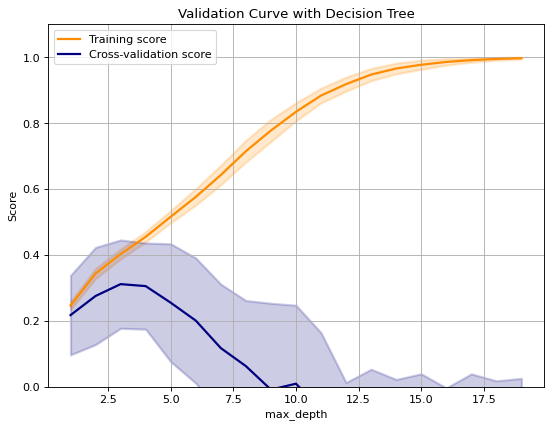

In [58]:
reg = DecisionTreeRegressor()

cv = ShuffleSplit(n_splits=10)
pr = np.arange(1, 20)
plot_validation_curve(reg, x_standard, y, pr, 'max_depth',
                          cv=cv, Modelname='Decision Tree', n_jobs=-1)
plt.grid()

the scores of validiation curve aren't really intresting, but it seems for max depth of 3 or 4 score is higher so we will use one of them.

now we fit the Decision Tree:

In [70]:
reg = DecisionTreeRegressor(max_depth = 3)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_standard)
print(f"the score on test data is {reg.score(x_test,y_test)}")

the score on test data is 0.4070240273428696


the score we get here does not look intresting, it seems it is not predicting well.

lets take a look at Learning Curve:

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

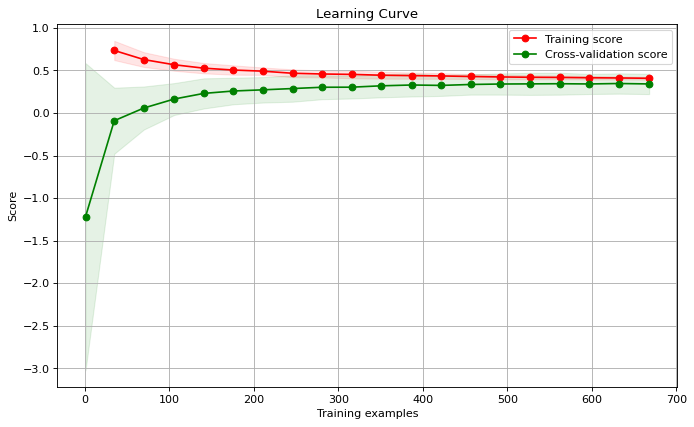

In [69]:
title = "Learning Curve"

estimator = DecisionTreeRegressor(max_depth = 3)

cv = ShuffleSplit(n_splits=50)
plot_learning_curve(estimator, title, x_standard, y, train_sizes=np.linspace(0.001, 1, 20), cv=cv, n_jobs=-1)

we can see gap betwin train scores and cross validation scores is closed at the right of the plot, so we might say number of samples we are useing for training is enough. the problem with our model is the features we are useing and we can say it is hard for our model to predict a day's pm25 rate from previous day's avarage temperture, pressure and wind speed.
 first thing we can do to get a better model is adding data of wind speed direction, humidty and rain  drop and some other features.
secondly we can give more precise data. avarage temperture, pressure and wind speed used here is for whole city of tehran. we can get better results if we use the data of the region we are trying to predict pollution. we can even give mentioned features for nearby regions for a more precise model and prediction.

thanks for your attention! :)